### Deep Learning by Dr Mohsin Ali at ITU
### Assignment 05
### Covid-19 Dataset




### Importing Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from IPython.display import clear_output # for clearing the output of a cell

% matplotlib inline

### Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q '/content/gdrive/My Drive/Asg5/Assignment 5 Dataset.zip'

In [0]:
data_dir = 'Assignment 5 Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=train_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
print(len(trainloader.dataset))
print(len(testloader.dataset))
print(len(valloader.dataset))

12000
1500
1500


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        title = "Label: " + str(title)
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# # Get a batch of training data
# inputs, classes = next(iter(trainloader))
# show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# print(vgg16.classifier[3])

### Freezing the layers (All Convolution Layers)

In [0]:
# Freezing training for all convolution layers
for param in vgg16.features.parameters(): # last convolution is not set to not train 
    param.requires_grad = False

### Making 2 FC Layer to be replaced in the VGG16

In [0]:
num_features = vgg16.classifier[0].in_features # getting the input features from the VGG16 in Fc layers
features = list([nn.Linear(num_features, 470)]) # my rollnumber = (37x10) + 100 = 470
features.extend([nn.Linear(470, len(class_names))])
print(features)

[Linear(in_features=25088, out_features=470, bias=True), Linear(in_features=470, out_features=2, bias=True)]


In [0]:
# features.extend([nn.Linear(num_features, len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss function and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Function for finding accuracy

In [0]:
from sklearn.metrics import confusion_matrix # for plotting confusuion matrix
from sklearn.metrics import f1_score # for finding f1 score

In [0]:
def get_accuracy(my_loader):
  correct = 0
  total = 0
  all_preds = list() # for saving all predictions
  orig_labels = list()
  with torch.no_grad():
      for data in my_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          
          all_preds.extend(predicted) # extending for predicted labels
          orig_labels.extend(labels) # extending for predicted labels

          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * (correct/total), orig_labels, all_preds

### Training

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_loss = []
train_acc = []

val_loss = []
val_acc = []


for epoch in range(Epochs):
  for part in ["training", "validation"]: # as every epoch has training and validation

    curr_loader =[] # current loading for storing the training and validation
    if part == "training":
      vgg16.train(True) # training is true for training data
      curr_loader = trainloader
      
    else:
      vgg16.train(False) # training is false for validation data
      curr_loader = valloader

    running_loss = 0.0 # for running loss
    running_acc = 0.0 # for running accuracy

    pbar = tqdm(enumerate(curr_loader)) # loading training data
    for i, data in pbar:
        # getting input
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()# zeroing the gradient

        outputs = vgg16(inputs)  
        loss = criterion(outputs, labels)

        if part == "training": # no learning from validation data
          loss.backward() 
          optimizer.step()

        _, preds = torch.max(outputs.data, 1)

        # print statistics
        running_loss += loss.item()
        running_acc += torch.sum(preds == labels)
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(curr_loader.dataset),
                100. * i / len(curr_loader),
                loss.data))
        
    # clear_output()
    if part == "training": # storing for training
      train_loss.append(running_loss)
      train_acc.append(running_acc)
    else: # storing for validation
      val_loss.append(running_loss)
      val_acc.append(running_acc)

    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 4 [1920/12000 (16%)]	Loss: 0.394368: : 30it [00:45,  1.43s/it]

Train Epoch: 4 [1920/12000 (16%)]	Loss: 0.394368: : 31it [00:45,  1.42s/it]

Train Epoch: 4 [1984/12000 (16%)]	Loss: 0.315671: : 31it [00:46,  1.42s/it]

Train Epoch: 4 [1984/12000 (16%)]	Loss: 0.315671: : 32it [00:46,  1.42s/it]

Train Epoch: 4 [2048/12000 (17%)]	Loss: 0.407414: : 32it [00:48,  1.42s/it]

Train Epoch: 4 [2048/12000 (17%)]	Loss: 0.407414: : 33it [00:48,  1.44s/it]

Train Epoch: 4 [2112/12000 (18%)]	Loss: 0.297829: : 33it [00:49,  1.44s/it]

Train Epoch: 4 [2112/12000 (18%)]	Loss: 0.297829: : 34it [00:49,  1.44s/it]

Train Epoch: 4 [2176/12000 (18%)]	Loss: 0.270817: : 34it [00:50,  1.44s/it]

Train Epoch: 4 [2176/12000 (18%)]	Loss: 0.270817: : 35it [00:51,  1.44s/it]

Train Epoch: 4 [2240/12000 (19%)]	Loss: 0.266587: : 35it [00:52,  1.44s/it]

Train Epoch: 4 [2240/12000 (19%)]	Loss: 0.266587: : 36it [00:52,  1.45s/it]

Train Epoch: 4 [2304/1200

Finished Training


### Plotting the Curves

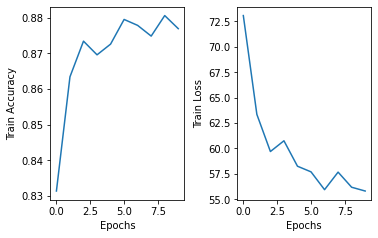

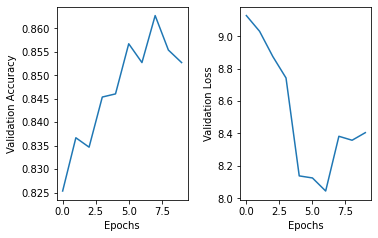

In [0]:
plt.subplot(121)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.plot(range(Epochs),np.asarray(train_acc)/12000)
plt.subplot(122)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.plot(range(Epochs),train_loss)
plt.show()

plt.subplot(121)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.plot(range(Epochs),np.asarray(val_acc)/1500)
plt.subplot(122)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.plot(range(Epochs),val_loss)
plt.show()

### Testing on Test Data and Plotting Confusion Matrix

Accuracy on testing dataset is  94.53333333333333
F1 score for testing dataset is  0.9545454545454545


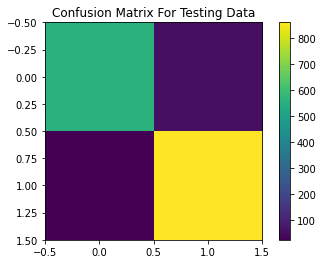

In [0]:
acc, my_orig, my_preds = get_accuracy(testloader)
print("Accuracy on testing dataset is ", acc)

my_orig = [int(i.cpu().numpy()) for i in my_orig]
my_preds = [int(i.cpu().numpy()) for i in my_preds]

print("F1 score for testing dataset is ", f1_score(my_orig, my_preds, average='binary'))

cf_matrix = confusion_matrix(my_orig, my_preds)
plt.imshow(cf_matrix)
plt.title("Confusion Matrix For Testing Data")
plt.colorbar()
plt.show()

### Plotting Confusion Matrices for Training and Validation Data

Accuracy on training dataset is  88.50833333333334
F1 score for training dataset is  0.903586660141229


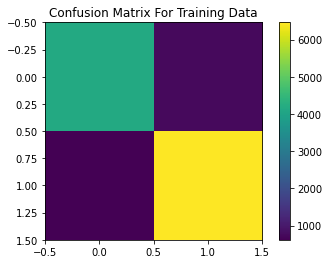

In [0]:
acc, my_orig, my_preds = get_accuracy(trainloader)
print("Accuracy on training dataset is ", acc)

my_orig = [int(i.cpu().numpy()) for i in my_orig]
my_preds = [int(i.cpu().numpy()) for i in my_preds]

print("F1 score for training dataset is ", f1_score(my_orig, my_preds,'binary'))

cf_matrix = confusion_matrix(my_orig, my_preds)
plt.imshow(cf_matrix)
plt.title("Confusion Matrix For Training Data")
plt.colorbar()
plt.show()

Accuracy on validation dataset is  86.6
F1 score for validation dataset is  0.8854700854700854


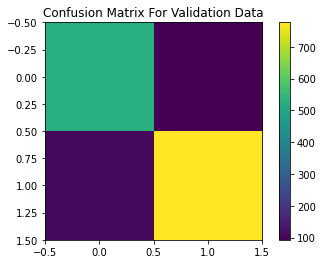

In [0]:
acc, my_orig, my_preds = get_accuracy(valloader)
print("Accuracy on validation dataset is ", acc)

my_orig = [int(i.cpu().numpy()) for i in my_orig]
my_preds = [int(i.cpu().numpy()) for i in my_preds]

print("F1 score for validation dataset is ", f1_score(my_orig, my_preds,'binary'))

cf_matrix = confusion_matrix(my_orig, my_preds)
plt.imshow(cf_matrix)
plt.title("Confusion Matrix For Validation Data")
plt.colorbar()
plt.show()

In [0]:
torch.save(vgg16.state_dict(), '/content/gdrive/My Drive/saved_models_asg5/vgg16_2FC.pth')

### Finding Best and Worst Classified Images

Best Image for class 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


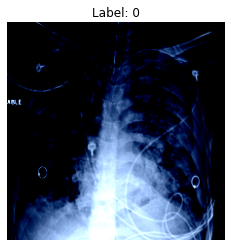

Best Image for class 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


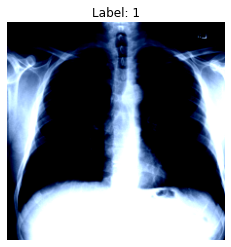

In [0]:
# best is the one which will have the maximum probability of 1 in the correct place
# worst is the one which will have the minimum probability of 1 in the wrong place
def find_best(my_loader, l):
  best = 0
  best_label = 0
  best_prob = 0
  with torch.no_grad():
      for data in my_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          
          for i in range(0,len(predicted)):
            if int(labels[i].cpu().numpy()) == l:
              if predicted[i] == labels[i]: # if same
                  if (outputs[i][labels[i]]>best_prob):
                    best_prob = outputs[i][labels[i]]
                    best = images[i]
                    best_label = labels[i]

  return best, best_label, best_prob

print("Best Image for class 0")
A = find_best(testloader, 0)
# print("The correct label of this image had probability of ",A[2].cpu().numpy())
imshow(A[0].cpu(),int(A[1].cpu()))

print("Best Image for class 1")
A = find_best(testloader, 1)
# print("The correct label of this image had probability of ",A[2].cpu().numpy())
imshow(A[0].cpu(),int(A[1].cpu()))

Worst Image for Class 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


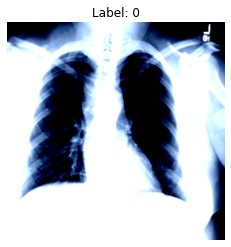

Worst Image for Class 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


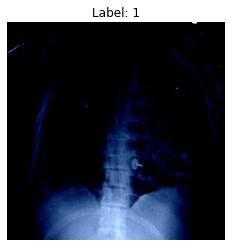

In [0]:
def find_worst(my_loader,l):
  worst = 0
  worst_label = 0
  worst_prob = 1
  with torch.no_grad():
      for data in my_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          
          for i in range(0,len(predicted)):
            if int(labels[i].cpu().numpy()) == l:
              if predicted[i] != labels[i]: # if same
                  if (outputs[i][labels[i]]<worst_prob):
                    worst_prob = outputs[i][labels[i]]
                    worst = images[i]
                    worst_label = labels[i]
  return worst, worst_label, worst_prob

print("Worst Image for Class 0")
A = find_worst(testloader,0)
# print("The correct label of this image had probability of ",A[2])
imshow(A[0].cpu(),int(A[1].cpu()))

print("Worst Image for Class 1")
A = find_worst(testloader,1)
# print("The correct label of this image had probability of ",A[2])
imshow(A[0].cpu(),int(A[1].cpu()))